## LSTM을 이용한 NAVER 주가 예측하기 + GRU
- https://coding-yoon.tistory.com/131
- https://alpaca-gt.tistory.com/300

In [3]:
!pip install pandas_datareader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 7.9 MB/s eta 0:00:00


#### 1. library load

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt

import datetime

import torch
import torch.nn as nn
from torch.autograd import Variable 

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


#### 2. NAVER 주식 불러오기 

<AxesSubplot:xlabel='Date'>

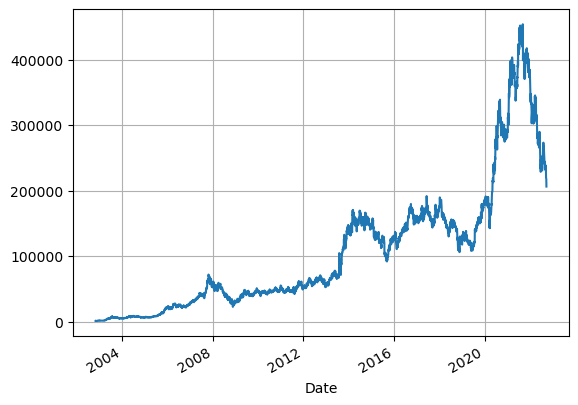

In [2]:
start = (2000, 1, 1)  # 2020년 01년 01월 
start = datetime.datetime(*start)  
end = datetime.date.today()  # 현재 

# yahoo 에서 NAVER 불러오기 
df = pdr.DataReader('035420.KS', 'yahoo', start, end)
df.Close.plot(grid=True)

In [3]:
df.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2002-10-29,1797.724854,1797.724854,1797.724854,1797.724854,501745.0,1761.037476
2002-10-30,2012.226074,1989.754517,2012.226074,2012.226074,20892185.0,1971.161255
2002-10-31,2091.897949,1865.139526,2042.869141,1912.125488,32327083.0,1873.103516
2002-11-01,2022.440430,1724.181519,1961.154419,1793.639038,18373668.0,1757.035156
2002-11-04,1789.553345,1660.852539,1777.296143,1703.752808,16939411.0,1668.983276


In [4]:
df.tail(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-09-16,223000.0,219500.0,221500.0,220000.0,777712.0,220000.0
2022-09-19,221000.0,217000.0,219500.0,218000.0,502182.0,218000.0
2022-09-20,222000.0,218000.0,220500.0,218000.0,240498.0,218000.0
2022-09-21,217000.0,212000.0,216500.0,213000.0,493972.0,213000.0
2022-09-22,209500.0,204000.0,207500.0,206500.0,685310.0,206500.0


In [5]:
df.shape

(4969, 6)

#### 3. 모델 성능 학습하기위해 데이터 분류하기

In [6]:
X = df.drop(columns='Volume')
y = df.iloc[:, 5:6]

print(X)
print(y)

                     High            Low           Open          Close  \
Date                                                                     
2002-10-29    1797.724854    1797.724854    1797.724854    1797.724854   
2002-10-30    2012.226074    1989.754517    2012.226074    2012.226074   
2002-10-31    2091.897949    1865.139526    2042.869141    1912.125488   
2002-11-01    2022.440430    1724.181519    1961.154419    1793.639038   
2002-11-04    1789.553345    1660.852539    1777.296143    1703.752808   
...                   ...            ...            ...            ...   
2022-09-16  223000.000000  219500.000000  221500.000000  220000.000000   
2022-09-19  221000.000000  217000.000000  219500.000000  218000.000000   
2022-09-20  222000.000000  218000.000000  220500.000000  218000.000000   
2022-09-21  217000.000000  212000.000000  216500.000000  213000.000000   
2022-09-22  209500.000000  204000.000000  207500.000000  206500.000000   

                Adj Close  
Date     

#### 4. 학습이 잘되기 위해 데이터 정규화 및 split

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

X_train, X_test, y_train, y_test = train_test_split(X_ss, y_mm, test_size=0.1, shuffle=True, random_state=34)

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (4472, 5) (4472, 1)
Testing Shape (497, 5) (497, 1)


- 학습할 수 있는 형태로 변환하기 위해 Torch로 변환
    - Torch의 Variable
        - data : a의 tensor 형태의 데이터가 담김
        - grad : data가 거쳐온 layer에 대한 미분값이 축적
        - grad_fn : 미분값을 계산한 함수에 대한 정보

In [8]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([4472, 1, 5]) torch.Size([4472, 1])
Testing Shape torch.Size([497, 1, 5]) torch.Size([497, 1])


#### 5. LSTM 네트워크 구성

In [9]:
device = torch.device('cpu')

In [10]:
class LSTM1(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM1, self).__init__()
    self.num_classes = num_classes #number of classes
    self.num_layers = num_layers #number of layers
    self.input_size = input_size #input size
    self.hidden_size = hidden_size #hidden state
    self.seq_length = seq_length #sequence length
 
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                      num_layers=num_layers, batch_first=True) #lstm
    self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
    self.fc = nn.Linear(128, num_classes) #fully connected last layer

    self.relu = nn.ReLU() 

  def forward(self,x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state   
    # Propagate input through LSTM

    output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
   
    hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
    out = self.relu(hn)
    out = self.fc_1(out) #first Dense
    out = self.relu(out) #relu
    out = self.fc(out) #Final Output
   
    return out 

- 네트워크 파라미터 구성

In [26]:
num_epochs = 10000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 5 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes

In [27]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)

loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)  # adam optimizer

#### 6. 학습

In [28]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final.to(device)) #       forward pass
  optimizer.zero_grad()     # caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = loss_function(outputs, y_train_tensors.to(device))

  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop

  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.05327
Epoch: 100, loss: 0.02204
Epoch: 200, loss: 0.01749
Epoch: 300, loss: 0.01737
Epoch: 400, loss: 0.01730
Epoch: 500, loss: 0.01723
Epoch: 600, loss: 0.01719
Epoch: 700, loss: 0.01717
Epoch: 800, loss: 0.01713
Epoch: 900, loss: 0.01709
Epoch: 1000, loss: 0.01703
Epoch: 1100, loss: 0.01691
Epoch: 1200, loss: 0.01672
Epoch: 1300, loss: 0.01602
Epoch: 1400, loss: 0.01169
Epoch: 1500, loss: 0.00019
Epoch: 1600, loss: 0.00006
Epoch: 1700, loss: 0.00005
Epoch: 1800, loss: 0.00005
Epoch: 1900, loss: 0.00004
Epoch: 2000, loss: 0.00004
Epoch: 2100, loss: 0.00004
Epoch: 2200, loss: 0.00004
Epoch: 2300, loss: 0.00003
Epoch: 2400, loss: 0.00003
Epoch: 2500, loss: 0.00003
Epoch: 2600, loss: 0.00003
Epoch: 2700, loss: 0.00003
Epoch: 2800, loss: 0.00003
Epoch: 2900, loss: 0.00002
Epoch: 3000, loss: 0.00002
Epoch: 3100, loss: 0.00002
Epoch: 3200, loss: 0.00002
Epoch: 3300, loss: 0.00004
Epoch: 3400, loss: 0.00001
Epoch: 3500, loss: 0.00001
Epoch: 3600, loss: 0.00001
Epoch: 3700, 

#### 7. 예측

In [29]:
df_X_ss = ss.transform(df.drop(columns='Volume'))
df_y_mm = mm.transform(df.iloc[:, 5:6])

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))

#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

In [30]:
df_X_ss.shape

torch.Size([4969, 1, 5])

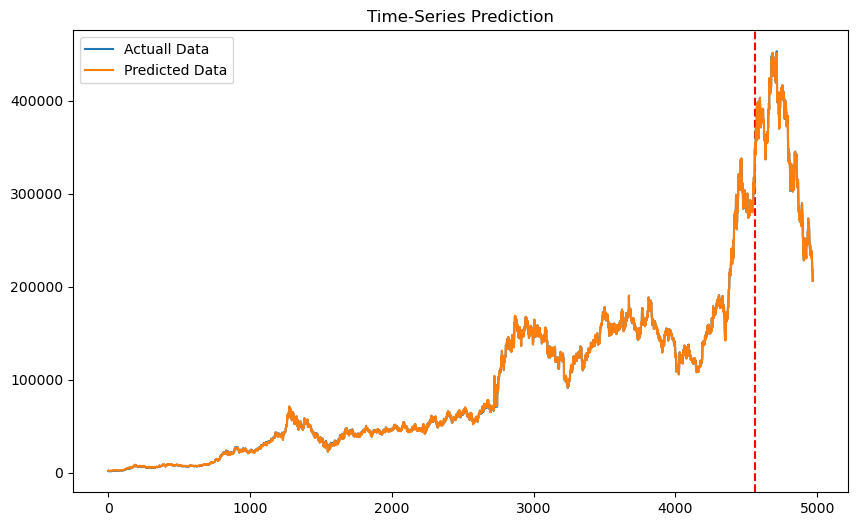

In [31]:
train_predict = lstm1(df_X_ss.to(device)) #forward pass
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

# Undo the scaling of X according to feature_range
data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=4563, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

#### + GRU MODEL

In [32]:
class GRU(nn.Module) :
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length) :
        super(GRU, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.gru = nn.GRU(input_size=input_size,hidden_size=hidden_size,
                         num_layers=num_layers,batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x) :
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        output, (hn) = self.gru(x, (h_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [33]:
num_epochs = 10000
learning_rate = 0.001

input_size=5
hidden_size=2
num_layers=1

num_classes=1
model=GRU(num_classes,input_size,hidden_size,num_layers,X_train_tensors_final.shape[1]).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [34]:
for epoch in range(num_epochs) :
    outputs = model.forward(X_train_tensors_final)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0 :
        print(f'Epoch : {epoch}, loss : {loss.item():1.5f}')

Epoch : 0, loss : 0.05224
Epoch : 100, loss : 0.00596
Epoch : 200, loss : 0.00081
Epoch : 300, loss : 0.00033
Epoch : 400, loss : 0.00018
Epoch : 500, loss : 0.00014
Epoch : 600, loss : 0.00012
Epoch : 700, loss : 0.00011
Epoch : 800, loss : 0.00010
Epoch : 900, loss : 0.00009
Epoch : 1000, loss : 0.00008
Epoch : 1100, loss : 0.00008
Epoch : 1200, loss : 0.00007
Epoch : 1300, loss : 0.00007
Epoch : 1400, loss : 0.00007
Epoch : 1500, loss : 0.00006
Epoch : 1600, loss : 0.00006
Epoch : 1700, loss : 0.00006
Epoch : 1800, loss : 0.00005
Epoch : 1900, loss : 0.00005
Epoch : 2000, loss : 0.00005
Epoch : 2100, loss : 0.00005
Epoch : 2200, loss : 0.00004
Epoch : 2300, loss : 0.00004
Epoch : 2400, loss : 0.00004
Epoch : 2500, loss : 0.00004
Epoch : 2600, loss : 0.00003
Epoch : 2700, loss : 0.00003
Epoch : 2800, loss : 0.00003
Epoch : 2900, loss : 0.00003
Epoch : 3000, loss : 0.00003
Epoch : 3100, loss : 0.00002
Epoch : 3200, loss : 0.00002
Epoch : 3300, loss : 0.00002
Epoch : 3400, loss : 0.000

In [35]:
df_X_ss = ss.transform(df.drop(columns='Volume'))
df_y_mm = mm.transform(df.iloc[:, 5:6])

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))

#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

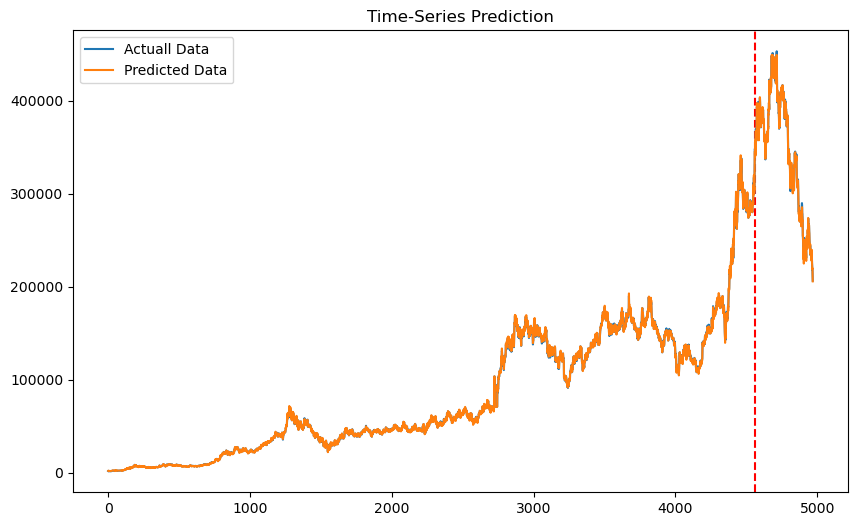

In [36]:
train_predict = model(df_X_ss.to(device)) #forward pass
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

# Undo the scaling of X according to feature_range
data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=4563, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 